### Кластеризация всех семейств  
1. Сохранение в датафрейм кластеризации всего банка и сравнение кластеризованных данных разными алгоритмами.  
2. Распределение количества выделенных кластеров на смоделированных данных (**старый** банк) сравнивается с распределением количества выделенных кластеров в экспериментальном банке.
3. Для рассмотренных алгоритмов кластеризации на **старом** модельном банке строится корреляционный плот: количество выделяемых кластеров по семействам в зависимости от среднего количества высот (иеальной кластеризации) в множестве, для которого выделяется такое количество кластеров.  (То есть, например, в 6, 10, 90 семействе всего 7, 4, 5 различных высот, но во всех трёх семействах алгоритмом выделено 5 кластеров. Координата точки корреляционного плота будет (5, 5.3) )

In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import datetime
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
import hdbscan
le_h = LabelEncoder()

In [49]:
# ГРАФИКА
large = 22; med = 18; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
sns.set(style="whitegrid")

In [4]:
def noise_cluster(labels):
    
    if -1 not in labels:
        return labels
    
    coef = len(set(labels))-1
    for i in range(len(labels)):  
        if labels[i] == -1:
            coef+=1
            labels[i] = labels[i]+coef
    return labels

In [5]:
# Функция вычисления матрицы расстояния для одного датафрейма по формуле физиков.
def Matrix_of_Distance(X, Y, E, label):
    Distance =[]
    for i in range(len(X)):
        Distance.append([])
        for j in range(len(Y)):
            
            if label == 1:
                Coef = 1
            elif label==2:
                Coef = math.sqrt(E[i]*E[j])
            elif label ==3:
                Coef=( E[i]*E[j])/(E[i] + E[j])
            
            r = Coef*(math.sqrt( math.pow((X[i]-X[j]),2) + math.pow((Y[i]-Y[j]),2) )  )
    
            Distance[i].append(r)
    
    return pd.DataFrame(Distance)

In [6]:
def CoefPFI(OneFamily, num, name = 'cluster'):
    P = 0
    E = 0
    DomH = [] #доминирующие высоты в кластерах
    N_c = len(OneFamily)
    
    labels = OneFamily[name]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    for i in range(n_clusters_):
        value = OneFamily[OneFamily[name]==i]['labels'].value_counts()
        n_d = value[:1].values
        n_c = len(OneFamily[OneFamily[name]==i][name])
        P_i = n_d[0]/n_c
        P = P + P_i
        
        x = value[:1].index[0]
        n_t = len(OneFamily[OneFamily['labels']==x])
        E_i = n_d[0]/n_t
        E = E + E_i
        
        DomH.append(x)
    
    purity = P/n_clusters_ #1
    
    splitting = len(set(DomH))/n_clusters_ #2
    
    integrity = len(set(DomH))/len(set(OneFamily['labels'])) #3
    
    efficiency =  E/n_clusters_ #4
    
    #CoefS = f'P = {round(purity,3)}, S = {round(splitting,3)}, I = {round(integrity, 3)}, E = {round(efficiency, 3)}'
   
    
    result = [num, round(purity,3), round(splitting,3), round(integrity,3), round(efficiency, 3) ]
    mean = np.mean(result[1:])
    var = np.var(result[1:])
    compose = (purity+efficiency)*(integrity+splitting)/4
    
    result = result+[round(mean,3)]
    result = result + [round(var,3)]
    result = result + [round(compose,3)]
    return result

In [7]:
def ClusteringAGLCLUST(eps, X):
    clustering = AgglomerativeClustering(n_clusters=None, affinity = 'precomputed', distance_threshold = eps, linkage = 'average').fit(X)
    labels = clustering.labels_    
    return labels

In [8]:
def ClusteringDBSCAN(eps, X):
    db = DBSCAN(eps=eps, min_samples = 1).fit(X)
    labels = db.labels_
    return noise_cluster(labels)

In [9]:
def ClusteringMeanShift(eps, X):
    clustering = MeanShift(bandwidth=eps).fit(X)
    labels = clustering.labels_
    return labels

In [10]:
def ClusteringOptics(eps, X):
    clustering = OPTICS(min_samples = 2).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [11]:
def ClusteringHdbscan(eps, X):
    clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                            gen_min_span_tree=False, leaf_size=1, min_cluster_size=2, min_samples=None, p=None).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [12]:
def ClusteringAffinity(eps, X):
    clustering = AffinityPropagation(damping = 0.9, random_state=5).fit(X)
    labels = clustering.labels_
    return labels

In [13]:
def clustering(data, name, exp = False):
    
    nums =list(set(data[name].values))
    clustered_df = []
    
    print('start: ', datetime.datetime.now())
    
    for i in nums:
        if i%100 == 0:
            print(i, datetime.datetime.now())
        
        # Выделяем семмейство
        df = data[data[name]==i].copy()
        
        # Строим матрицу расстояний со вторым коэффициентом расстояния
        X = Matrix_of_Distance(df['X(J)'].values, df['Y(J)'].values, df['E(J)'].values, 2)
        
        eps = np.percentile(df['ER'], 80)
        df['cluster_agl'] = ClusteringAGLCLUST(eps, X)
                
        eps = np.percentile(df['ER'], 100)
        df['cluster_db'] = ClusteringDBSCAN(eps, X)
        
        eps = np.percentile(df['ER'], 100)
        df['cluster_ms'] = ClusteringMeanShift(eps, X)
        
        df['cluster_op'] = ClusteringOptics(eps, X)
        
        df['cluster_hd'] = ClusteringHdbscan(eps, X)
        
        df['cluster_af'] = ClusteringAffinity(eps, X)
        
        clustered_df.append(df)
        
    
    clustered_df = pd.concat(clustered_df)

    return clustered_df

In [14]:
# Новый модельный банк.
AllMc0 = pd.read_csv('datachanged/AllMc0CNewBank', sep = '\t')
# Старый модельный банк.
olddata = pd.read_csv('datachanged/AllMc0COld', sep = '\t')

In [15]:
# Экспериментальные данные.
AllExp = pd.read_csv('datachanged/AllExpC')
AllExp = AllExp.drop(['Unnamed: 0'], axis = 1)

In [21]:
%%time
clustered_df = clustering(AllMc0, 'num')

start:  2022-01-05 14:30:38.539864
100 2022-01-05 14:30:45.009570
200 2022-01-05 14:30:51.048454
300 2022-01-05 14:30:57.295727
400 2022-01-05 14:31:02.978729
500 2022-01-05 14:31:09.511346
600 2022-01-05 14:31:17.659540
700 2022-01-05 14:31:58.763011
800 2022-01-05 14:32:23.027146
900 2022-01-05 14:35:43.757864
1000 2022-01-05 14:36:12.925965
1100 2022-01-05 14:36:34.919147
1200 2022-01-05 14:37:29.625606
1400 2022-01-05 14:39:54.932787
1500 2022-01-05 15:09:08.685838
1600 2022-01-05 15:11:27.937685
1700 2022-01-05 15:12:04.132317
1800 2022-01-05 15:36:01.007710
1900 2022-01-05 15:36:34.163079
2000 2022-01-05 15:39:39.865921
2100 2022-01-05 15:42:17.836948
2200 2022-01-05 15:51:48.584749
2300 2022-01-05 15:57:42.837436
Wall time: 1h 27min 10s


In [25]:
clustered_df.head()

,j,X(J),Y(J),E(J),H(J),E0,A0,log_E0,num,R,ER,sum_energy,lg_r,lg_e_r,cluster_agl,cluster_db,cluster_ms,cluster_op,cluster_hd,cluster_af
0,1,-3.013189,-7.227429,4.611031,1255.250,3366.712,1,3.527206,1,7.830392,36.106180,370.199507,0.893784,1.557582,3,0,0,7,2,0
1,2,-1.310529,-2.563248,12.047700,1545.054,3366.712,1,3.527206,1,2.878841,34.683415,370.199507,0.459218,1.540122,0,0,0,8,3,0
2,3,-2.178048,-2.144561,5.401844,3044.520,3366.712,1,3.527206,1,3.056638,16.511481,370.199507,0.485244,1.217786,0,0,0,9,1,0
3,4,-0.965465,-0.082880,5.325506,4715.523,3366.712,1,3.527206,1,0.969016,5.160501,370.199507,-0.013669,0.712692,0,0,0,2,1,0
4,5,-1.621645,0.079540,15.935060,3044.520,3366.712,1,3.527206,1,1.623595,25.872076,370.199507,0.210478,1.412831,0,0,0,10,1,0


In [27]:
#%%time
clustered_df_old = clustering(olddata, ' num_of_family')

start:  2022-01-30 20:11:27.829056
100 2022-01-30 20:11:38.084609
200 2022-01-30 20:11:54.010013
300 2022-01-30 20:12:02.085400
400 2022-01-30 20:12:09.728102
500 2022-01-30 20:12:17.550526
600 2022-01-30 20:12:25.560087
700 2022-01-30 20:12:34.076294
800 2022-01-30 20:12:44.320875
900 2022-01-30 20:12:54.354056
1000 2022-01-30 20:13:03.167593
1100 2022-01-30 20:13:13.623575
1200 2022-01-30 20:13:23.397340


In [28]:
clustered_df_old.head()

,num_of_family,j,X(J),Y(J),E(J),H(J),E0,A0,log_E0,R,ER,sum_energy,cluster_agl,cluster_db,cluster_ms,cluster_op,cluster_hd,cluster_af
0,1,1,-3.013189,-7.227429,4.611031,1255.250,3366.712,1,3.527206,7.830392,36.106180,370.199507,3,0,0,7,2,0
1,1,2,-1.310529,-2.563248,12.047700,1545.054,3366.712,1,3.527206,2.878841,34.683415,370.199507,0,0,0,8,3,0
2,1,3,-2.178048,-2.144561,5.401844,3044.520,3366.712,1,3.527206,3.056638,16.511481,370.199507,0,0,0,9,1,0
3,1,4,-0.965465,-0.082880,5.325506,4715.523,3366.712,1,3.527206,0.969016,5.160501,370.199507,0,0,0,2,1,0
4,1,5,-1.621645,0.079540,15.935060,3044.520,3366.712,1,3.527206,1.623595,25.872076,370.199507,0,0,0,10,1,0


In [23]:
%%time
clustered_df_exp = clustering(AllExp, ' num_of_fam')

start:  2022-01-05 15:57:49.171775
200 2022-01-05 15:58:11.943946
300 2022-01-05 15:58:20.015370
400 2022-01-05 15:58:32.265620
500 2022-01-05 15:58:49.075196
600 2022-01-05 15:59:00.828780
700 2022-01-05 15:59:11.875248
800 2022-01-05 15:59:22.841932
900 2022-01-05 15:59:34.686270
Wall time: 1min 48s


In [18]:
clustered_df_exp.head()

,num_of_fam,j,X(J),Y(J),E(J),R,cnt,ER,sum_energy,lg_r,lg_e_r,cluster_agl,cluster_db,cluster_ms,cluster_op,cluster_hd,cluster_af
0,1,1,0.2513,-1.0370,20.896,1.067015,13,22.296342,145.8,0.028170,1.348234,0,0,0,0,2,0
1,1,2,0.6003,-0.5482,13.749,0.812947,13,11.177213,145.8,-0.089938,1.048334,0,0,0,4,1,0
2,1,3,0.3081,-1.0631,11.535,1.106846,13,12.767464,145.8,0.044087,1.106105,0,0,0,1,3,0
3,1,4,0.6618,-0.5704,6.129,0.873691,13,5.354850,145.8,-0.058642,0.728747,0,0,0,2,1,0
4,1,5,0.5843,-0.5611,8.619,0.810086,13,6.982133,145.8,-0.091469,0.843988,0,0,0,3,1,0


In [27]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df.to_csv('clusterdata/clusteredDF', sep = '\t', index = False)

In [30]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df_old.to_csv('clusterdata/clusteredDFold', sep = '\t', index = False)

In [28]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df_exp.to_csv('clusterdata/clusteredDFexp', sep = '\t', index = False)

### Распределение по количеству выделенных кластеров в модели и в эксперименте.

In [17]:
#clustered_df = pd.read_csv('clusterdata/clusteredDF', sep = '\t')
clustered_df_exp = pd.read_csv('clusterdata/clusteredDFexp', sep = '\t')
clustered_df_old = pd.read_csv('clusterdata/clusteredDFold', sep = '\t')

In [19]:
def unique_clust(data, name, clust):
    nums = list(set(data[name]))
    Unique_H = []
    
    for num in nums:
        value = len(data[data[name]==num][clust].unique())
        Unique_H.append(value)
        
    return Unique_H

In [20]:
# Распределение по количеству выделенных кластеров в семействах

#uniq_h_new = unique_clust(clustered_df, 'num', 'cluster_agl')
uniq_h_old = unique_clust(clustered_df_old, ' num_of_family', 'cluster_agl')
uniq_h_exp = unique_clust(clustered_df_exp, ' num_of_fam', 'cluster_agl')

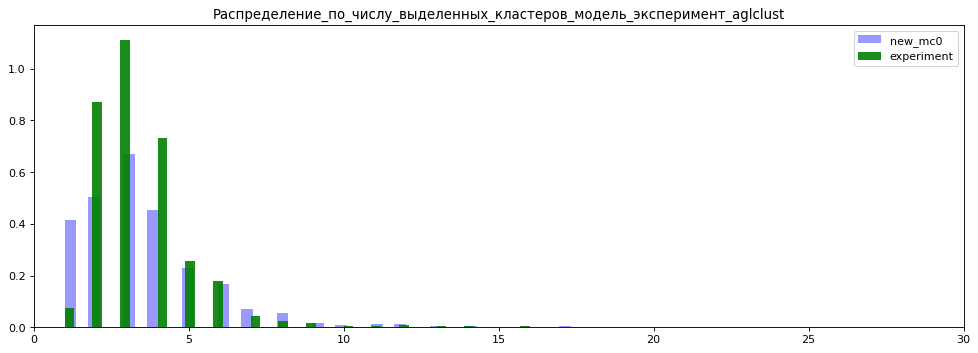

In [32]:
# Распределение по высотам
tit = 'Распределение_по_числу_выделенных_кластеров_модель_эксперимент_aglclust'
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title(tit)
plt.hist(uniq_h_old, bins = 50, density = True, alpha = 0.4, color  = 'blue', label = 'new_mc0')
plt.hist(uniq_h_exp, bins = 50, density = True, alpha = 0.9, color = 'green', label = 'experiment')
#plt.savefig(f'images/distributions/{tit}.png')
plt.xlim([0,30])
plt.legend()
plt.show()

In [134]:
def psi(expected_array, actual_array, buckets=10):
    ''' Эта метрика позволяет измерить то, 
    насколько переменная изменилась в распределении между двумя выборками.
    Чем больше, тем сильнее изменение.
    '''
    def scale_range (array, min_arr, max_arr):
        array += -(np.min(array))
        array /= np.max(array) / (max_arr - min_arr)
        array += min_arr
        return array
    
    expected_array = np.array(expected_array)
    actual_array = np.array(actual_array)
    
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    
    expected = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
    expected = np.where(expected == 0, 0.00001, expected)
    actual = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
    actual = np.where(actual == 0, 0.00001, actual)
    
    psi_value = np.sum((expected - actual)*np.log(expected/actual))
    return psi_value 

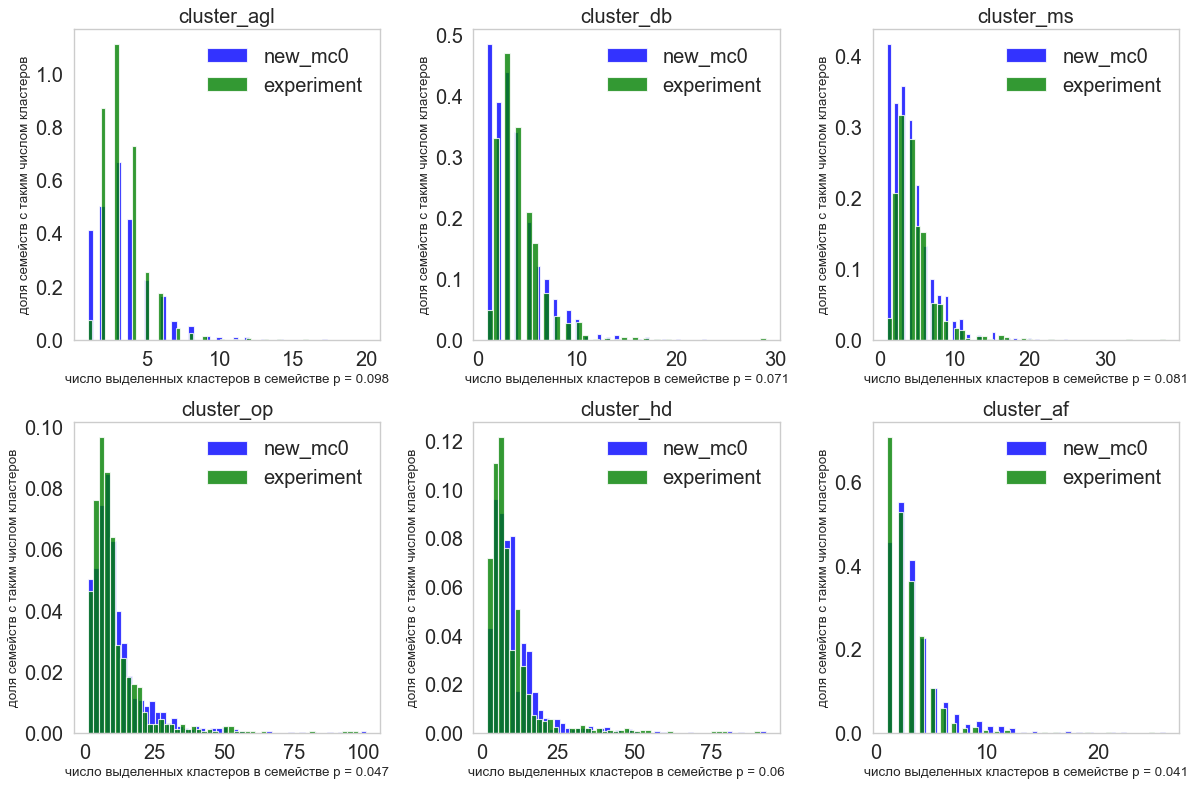

In [136]:
algorithm = ['cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_hd', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams.update(params)

for i in range(6): 
    
    uniq_h_old = unique_clust(clustered_df_old, ' num_of_family', algorithm[i])
    uniq_h_exp = unique_clust(clustered_df_exp, ' num_of_fam', algorithm[i])
    # stat, p = np.around(mannwhitneyu(uniq_h_old, uniq_h_exp), 3)
    p = round(psi(uniq_h_old, uniq_h_exp),3)
    
    plt.subplot(2, 3, i+1)
    plt.rcParams.update(params)
    plt.title(algorithm[i])
    
    plt.hist(uniq_h_old, bins=50, density=True, alpha=0.8, color='blue', label='new_mc0')
    plt.hist(uniq_h_exp, bins=50, density=True, alpha=0.8, color='green', label='experiment')
    
    plt.grid()
    plt.legend()
    plt.xlabel(f'число выделенных кластеров в семействе p = {p}', size=12)
    plt.ylabel('доля семейств с таким числом кластеров', size=12)
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/mc0_exp.png')

### Корреляционный плот - число уникальных высот высот - число кластеров выделенных алгоритмов кластеров (в среднем) для такого числа высот

In [22]:
def return_number_h_cluster(data, name, clust):
    
    nums = list(set(data[name]))

    number_dom_h = []
    number_clusters = []
    
    for num in nums:

        # Выделяем одно семейство
        one = data[data[name]==num].copy()
        
        clusters = []
        dom_h_one = []
                    
        # число кластеров  
        number_clusters.append(len(one[clust].unique()))
        
        # число высот в семействе         
        number_h_one = len(one['H(J)'].unique())
        number_dom_h.append(number_h_one)
            
    return pd.DataFrame({'num': nums,'number_h':number_dom_h, 'number_clusters': number_clusters})

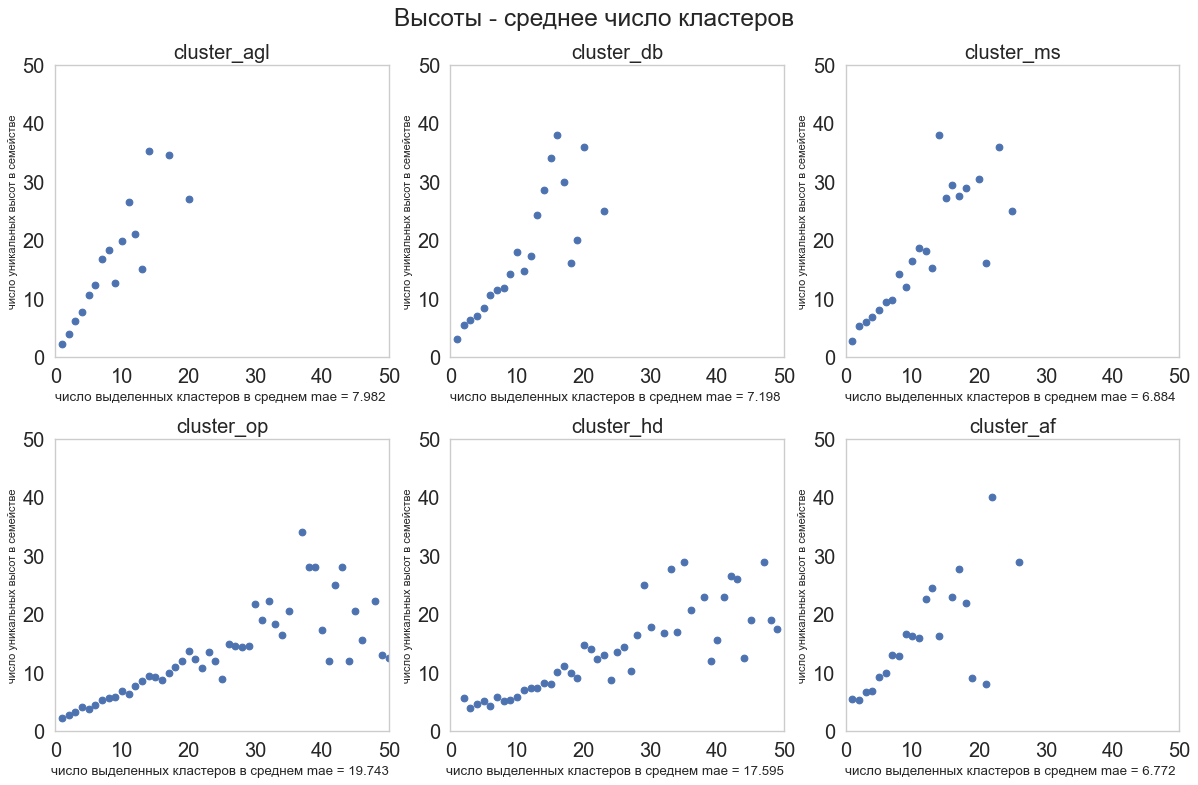

In [87]:
algorithm = ['cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_hd', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Высоты - среднее число кластеров')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').mean().reset_index()
    m = round(mae(plotdf['number_clusters'], plotdf['number_h']), 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(plotdf['number_clusters'], plotdf['number_h'],  'o')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в среднем mae = {m} ', size=12)
    plt.ylabel('число уникальных высот в семействе', size=10)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    plt.grid()
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/h_mean_clust.png')

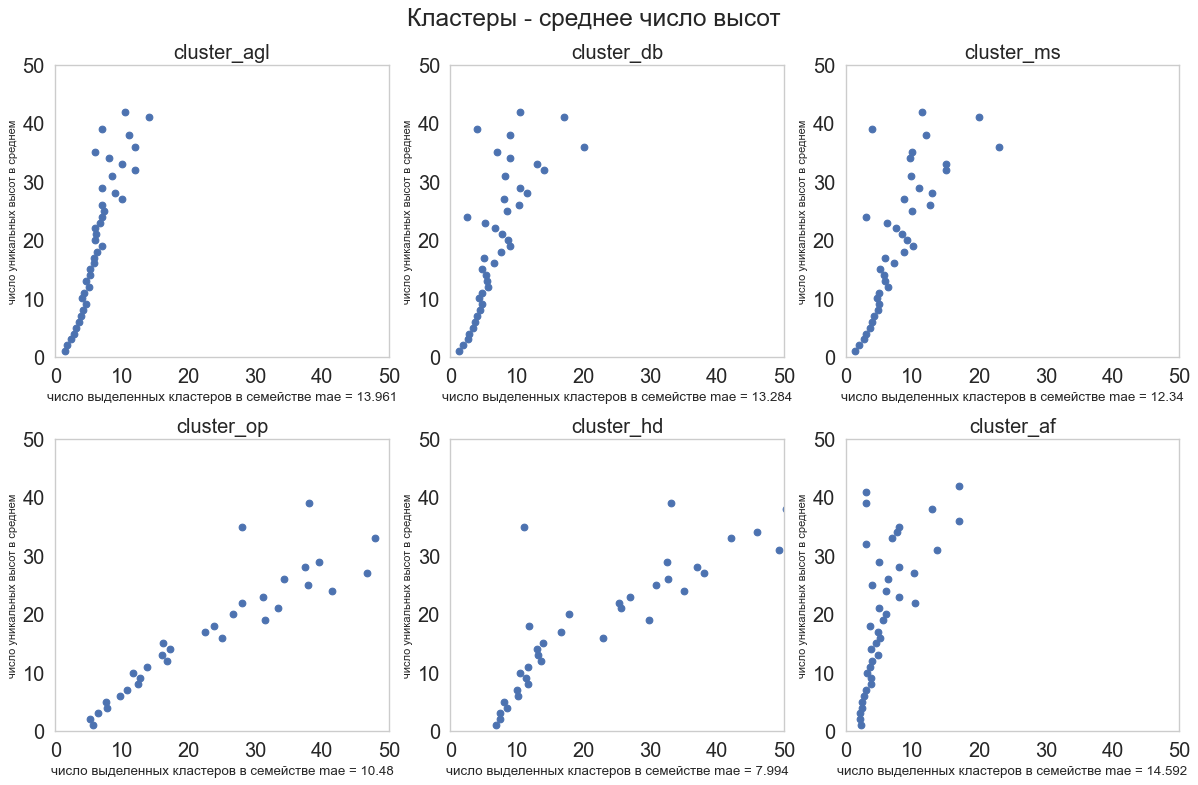

In [88]:
algorithm = ['cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_hd', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Кластеры - среднее число высот')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_h').mean().reset_index()
    m = round(mae(plotdf['number_clusters'], plotdf['number_h']), 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(plotdf['number_clusters'], plotdf['number_h'],  'o')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе mae = {m}', size=12)
    plt.ylabel('число уникальных высот в среднем', size=10)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    plt.grid()
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/mean_h_clust.png')